AR(1) coefficient (phi) = 0.0303
Using residuals for Hurst analysis...


100%|██████████| 819/819 [00:03<00:00, 268.35it/s] 


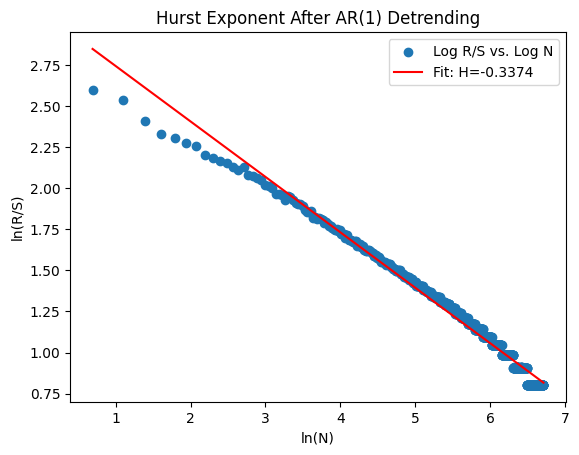

Hurst exponent H (after AR(1) adjustment) = -0.3374


In [93]:
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from tqdm import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Download stock data
df = yf.download("F", start='2012-01-01', progress=False, rounding=2)
data = np.log(df['Close'] / df['Close'].shift(1)).dropna()

# AR(1) Process: Estimate and remove linear dependence
Y = data[1:].values
X = data[:-1].values
X = sm.add_constant(X)  # Add intercept
model = sm.OLS(Y, X).fit()
phi = model.params[1]  # AR(1) coefficient

# Compute residuals (detrended data)
residuals = model.resid

print(f"AR(1) coefficient (phi) = {phi:.4f}")
print("Using residuals for Hurst analysis...")

# Hurst exponent calculation using residuals
RS_means = []
M = len(residuals)
max_N = int(M / 4)

for A in tqdm(range(2, max_N)):
    N = int(M / A)
    R_S_divs = []
    
    for iter in range(1, A + 1):
        I_a = residuals[N * (iter - 1): N * iter]
        if len(I_a) < 2:
            continue

        R_a = max(I_a) - min(I_a)
        S_a = np.std(I_a, ddof=1)

        if S_a > 0:
            R_S_divs.append(R_a / S_a)

    if R_S_divs:
        RS_mean = np.mean(R_S_divs)
        RS_means.append(RS_mean)

# Linear regression for Hurst exponent
N_values = np.array(range(2, max_N))
valid_indices = np.where(np.array(RS_means) > 0)
ln_Ns_valid = np.log(N_values[valid_indices])
ln_RS_valid = np.log(np.array(RS_means)[valid_indices])

H, intercept, _, _, _ = linregress(ln_Ns_valid, ln_RS_valid)

# Plot the regression for verification
plt.scatter(ln_Ns_valid, ln_RS_valid, label="Log R/S vs. Log N")
plt.plot(ln_Ns_valid, H * ln_Ns_valid + intercept, color='red', label=f"Fit: H={H:.4f}")
plt.xlabel("ln(N)")
plt.ylabel("ln(R/S)")
plt.legend()
plt.title("Hurst Exponent After AR(1) Detrending")
plt.show()

print(f"Hurst exponent H (after AR(1) adjustment) = {H:.4f}")


In [97]:
import pywt

def hurst_wavelet(price_series):
    """
    Calculates the Hurst Exponent using the wavelet transform method.
    """
    # Compute log returns
    log_returns = np.diff(np.log(price_series))
    
    # Calculate the wavelet transform
    coeffs = pywt.wavedec(log_returns, 'db8', level=int(np.log2(len(log_returns))))
    
    # Calculate the variance for each scale
    coeffs_len = len(coeffs)
    variance = [np.mean(np.square(c)) for c in coeffs]
    
    # Calculate the slope of the log-log plot of variance vs scale
    scales = np.arange(coeffs_len)
    poly = np.polyfit(np.log2(scales), np.log2(variance), 1)
    
    # The Hurst exponent is the slope of the linear fit
    hurst_exponent = poly[0]
    
    # The fractal dimension is related to the Hurst exponent
    fractal_dimension = 2 - hurst_exponent
    
    return hurst_exponent, fractal_dimension
        

In [100]:
def hurst_rs(price_series):
    """
    Calculates the Hurst Exponent using the Rescaled Range (R/S) analysis method.
    """
    # Compute log returns
    log_returns = np.diff(np.log(price_series))
    
    # Create an array of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(log_returns[lag:], log_returns[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # The Hurst exponent is the slope of the linear fit
    hurst_exponent = poly[0]*2.0
    
    # The fractal dimension is related to the Hurst exponent
    fractal_dimension = 2 - hurst_exponent
    
    return hurst_exponent, fractal_dimension
        

In [101]:
h, f = hurst_rs(df['Close'])

In [112]:
df = yf.download("F", start='2012-01-01', progress=False, rounding=2)

In [131]:
df = df.iloc[2000:, :]
hs = []
fs = []
for i in range(1088):
    h, f = hurst_rs(df['Close'].iloc[i:i+200])
    hs.append(h)
    fs.append(f)

In [132]:
len(df['Close'].iloc[200:]), len(hs)

(1088, 1088)

/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_16098/713412949.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 600x1200 with 0 Axes>

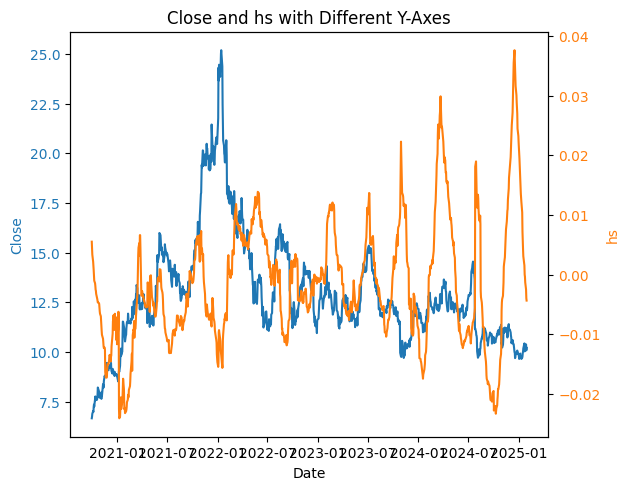

In [134]:
dfs = df.iloc[200:, :]
dfs['hs'] = hs
import matplotlib.pyplot as plt

# Assuming 'dfs' is your dataframe with columns 'Close' and 'hs'
plt.figure(figsize=(6, 12))
fig, ax1 = plt.subplots()
# Plot the 'Close' column on the first y-axis
ax1.plot(dfs.index, dfs['Close'], color='tab:blue', label='Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the 'hs' column on the second y-axis
ax2.plot(dfs.index, dfs['hs'], color='tab:orange', label='hs')
ax2.set_ylabel('hs', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Show the plot
fig.tight_layout()  # Ensure everything fits without overlapping
plt.title('Close and hs with Different Y-Axes')
plt.show()


In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def hurst_exponent(ts, max_lag=100):
    lags = np.array(range(2, max_lag))  # Convert range to NumPy array
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    
    log_lags = np.log(lags)  # Ensure lags is a NumPy array
    log_tau = np.log(tau)
    hurst, _ = np.polyfit(log_lags, log_tau, 1)
    return hurst

# Download stock data
def get_stock_hurst(ticker, start='2020-01-01', end='2025-01-01', window=240):
    stock_data = yf.download(ticker, start=start, end=end)['Adj Close']
    returns = np.log(stock_data / stock_data.shift(1)).dropna()
    
    rolling_hurst = returns.rolling(window).apply(hurst_exponent, raw=True)
    H = hurst_exponent(returns.values)
    return H, stock_data, rolling_hurst

# Example: Analyze AAPL stock
if __name__ == "__main__":
    ticker = '^TWII'  # Change to any stock symbol
    H, prices, rolling_hurst = get_stock_hurst(ticker)
    
    print(f'Hurst Exponent for {ticker}: {H:.4f}')
    
    # Plot using Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=prices.index, y=prices, mode='lines', name=f'{ticker} Adjusted Close'))
    fig.add_trace(go.Scatter(x=rolling_hurst.index, y=rolling_hurst, mode='lines', name='Rolling Hurst (240 days)', yaxis='y2'))
    
    fig.update_layout(
        title=f'{ticker} Stock Price and Rolling Hurst Exponent',
        xaxis_title='Date',
        yaxis=dict(title='Price', side='left'),
        yaxis2=dict(title='Hurst Exponent', overlaying='y', side='right'),
        legend=dict(x=0, y=1),
    )
    fig.show()
    
    # Interpretation
    if H < 0.5:
        print("The stock is likely mean-reverting.")
    elif H > 0.5:
        print("The stock is likely trending.")
    else:
        print("The stock behaves like a random walk.")


[*********************100%***********************]  1 of 1 completed


Hurst Exponent for ^TWII: -0.0123


The stock is likely mean-reverting.


In [15]:
import pandas as pd
import yfinance as yf
import numpy as np
import plotly.graph_objects as go

In [26]:
y_ks_a

-0.27529908143759724

In [ ]:
from tqdm import tqdm
df = yf.download("F", start='2012-01-01', progress=False, rounding=2)
data = np.log(df['Close'] / df['Close'].shift(1)).dropna()

RS_means = []
M = len(data); N = 10;
max_N = int(M/4)
for A in tqdm(range(2, max_N)):
    N = int(M/A)
    R_as = []
    S_as = []
    R_S_divs = []
    for iter in range(1, A+1):
        I_a = data[N*(iter-1):N*iter]
        e_a = (sum(I_a))/N
        y_ks_a = 
        R_a = max(y_ks_a) - min(y_ks_a)
        # S_a = np.sqrt(np.power(sum(I_a) - e_a, 2))
        S_a = np.std(I_a, ddof=1)
        R_S_div = R_a / S_a
        R_as.append(R_a)
        S_as.append(S_a)
        R_S_divs.append(R_S_div)
    RS_mean = np.mean(R_S_divs)
    RS_means.append(RS_mean)

100%|██████████| 819/819 [00:12<00:00, 67.47it/s] 


In [ ]:
import numpy as np
import yfinance as yf
from tqdm import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt

# 下載數據並計算對數收益率
df = yf.download("F", start='2020-01-01', progress=False, rounding=2)
data = np.log(df['Close'] / df['Close'].shift(1)).dropna()

RS_means = []
N_values = []
M = len(data)
max_N = int(M / 2)

for N in tqdm(range(2, max_N)):
    A = int(M / N)
    if A < 2:
        break

    R_S_divs = []
    for iter in range(1, N + 1):
        I_a = data[A * (iter - 1): A * iter]
        if len(I_a) < 2:  # 過濾過短的區段
            continue

        e_a = np.mean(I_a)
        y_ks_a = I_a - e_a
        if len(y_ks_a) > 1:
            R_a = max(y_ks_a) - min(y_ks_a)
            S_a = np.std(I_a, ddof=1)  # 使用標準差

            if S_a > 0:
                R_S_divs.append(R_a / S_a)

    if R_S_divs:
        RS_mean = np.mean(R_S_divs)
        RS_means.append(RS_mean)
        N_values.append(N)

# 過濾有效數據
RS_means = np.array(RS_means)
N_values = np.array(N_values)
valid_indices = np.where(RS_means > 0)
ln_Ns_valid = np.log(N_values[valid_indices])
ln_RS_valid = np.log(RS_means[valid_indices])

# 繪製數據點以檢查趨勢
plt.scatter(ln_Ns_valid, ln_RS_valid, label="R/S vs. N")
plt.xlabel("ln(N)")
plt.ylabel("ln(R/S)")
plt.title("Hurst 指數回歸分析")
plt.legend()
plt.show()

# 計算 Hurst 指數
if len(ln_Ns_valid) > 1:
    H, intercept, r_value, p_value, std_err = linregress(ln_Ns_valid, ln_RS_valid)
    print(f"Hurst 指數 H = {H:.4f}")
else:
    print("錯誤：沒有足夠的有效數據計算 Hurst 指數")


In [91]:
from scipy.stats import linregress
valid_indices = np.where(np.array(RS_means) > 0)  # 只保留 R/S > 0 的數據
ln_Ns_valid = np.log2(np.array(range(2, max_N))[valid_indices])
ln_RS_valid = np.log2(np.array(RS_means)[valid_indices])
H, intercept, r_value, p_value, std_err = linregress(ln_Ns_valid, ln_RS_valid)
H, intercept

(np.float64(-0.3358820027010178), np.float64(4.435582000885397))

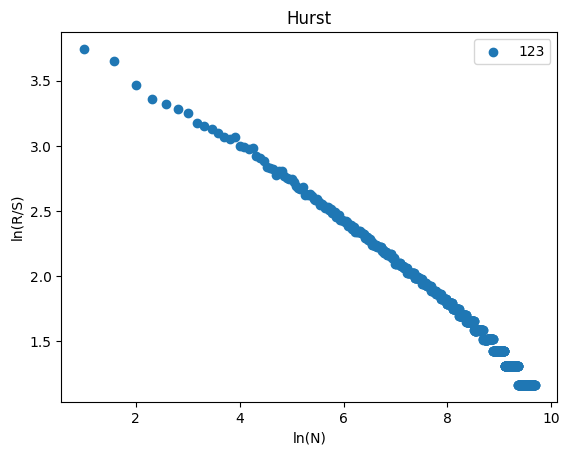

In [92]:
import matplotlib.pyplot as plt

plt.scatter(ln_Ns_valid, ln_RS_valid, label="123")
plt.xlabel("ln(N)")
plt.ylabel("ln(R/S)")
plt.title("Hurst")
plt.legend()
plt.show()


In [59]:
import numpy as np
import yfinance as yf
from tqdm import tqdm
from scipy.stats import linregress

df = yf.download("^TWII", start='2020-01-01', progress=False, rounding=2)
data = df['Close'].pct_change().dropna()

RS_means = []
M = len(data)
max_N = int(M / 2)

ln_Ns_reg = []
for N in tqdm(range(2, max_N)):
    A = int(M / N)
    if A < 2:  # 避免區間長度過小
        break

    R_S_divs = []
    for iter in range(1, N+1):
        I_a = data[A * (iter-1): A * iter]
        if len(I_a) < 2:  # 確保區間內至少有兩個數據點
            continue

        e_a = np.mean(I_a)
        y_ks_a = I_a - e_a
        R_a = max(y_ks_a) - min(y_ks_a)
        S_a = np.std(I_a, ddof=1)  # 正確標準差計算

        if S_a > 0:  # 避免除以 0
            R_S_divs.append(R_a / S_a)

    if R_S_divs:
        RS_mean = np.mean(R_S_divs)
        RS_means.append(RS_mean)
        ln_Ns_reg.append(np.log2(N))  # 正確計算 ln(N)

# 進行線性回歸
ln_RS_means = np.log(RS_means)  # 修正：對 RS_means 取對數
H, intercept, r_value, p_value, std_err = linregress(ln_Ns_reg, ln_RS_means)

print(f"Hurst 指數 H = {H:.4f}")
print(f"截距 Intercept = {intercept:.4f}")


100%|██████████| 612/612 [00:14<00:00, 41.30it/s] 

Hurst 指數 H = -0.2936
截距 Intercept = 3.0932
